In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi

In [2]:
import qcgpu

In [3]:
#Creation and normalization of an array with gaussian probabilities
def gauss(x, mu, sigma):
    dx = x[1]-x[0]
    g = (1/(np.sqrt(2*pi*sigma**2)))*np.exp(-((x-mu)**2)/(2*sigma**2))
    f = g*dx/(np.sum(g * dx))
    return f

In [4]:
def log_normal(x, mu, sig):
    dx = []
    log_norm = 1 / (x * sig * np.sqrt(2 * np.pi)) * np.exp(- np.power(np.log(x) - mu, 2.) / (2 * np.power(sig, 2.)))
    dx.append(x[1]-x[0])
    for i in range(1,len(x)):
        dx.append(x[i]-x[i-1])
    dx = np.array(dx)

    f = log_norm*dx/(np.sum(log_norm * dx))
    return f

In [5]:
#Variational circuit that simulates a quantum random walk of a particle
def DirectCircuit(qubits, parameters):
    if qubits%2==0: raise ValueError('Try odd number of qubits')
    C = qcgpu.State(qubits+1)
    mid = int((qubits-1)/2)
    C.x(mid)
    for i in range(mid):
        C.cx(mid-i, mid-i-1)
        C.cu(mid-i-1, mid-i, parameters[mid-i-1], 0, 0)
        C.cx(mid-i, mid-i-1)
        C.cx(mid+i, mid+i+1)
        C.cu(mid+i+1, mid+i, parameters[mid+i], 0, 0)
        C.cx(mid+i, mid+i+1)
    return C

In [6]:
#Parameter creation for the first step of the variational algorithm
def parameters(qubits):
    a = int((qubits-1))
    p = 2*pi*np.random.random((a,))
    return p

In [7]:
def DirectParameters(qubits, mu, sigma, S, lognormal=False):
    if lognormal==True:
        ga = log_normal(S, mu, sigma)
    else:
        ga = gauss(S, mu, sigma)
    mid = int((qubits-1)/2)
    last = 1
    parameters = []
    for i in range(mid-1):
        angle = 2 * np.arctan(np.sqrt(ga[i]/(ga[i+1] * last)))
        parameters.append(angle)
        last = (np.cos(angle/2))**2
    angle = 2 * np.arcsin(np.sqrt(ga[mid-1]/last))
    parameters.append(angle)
    last = (np.cos(angle/2))**2
    for i in range(mid, qubits-1):
        angle = 2 * np.arccos(np.sqrt(ga[i]/last))
        parameters.append(angle)
        last *= (np.sin(angle/2))**2
    return parameters

In [8]:
#Probability distribution of the circuit's final state
def result(par, qubits):
    circ = DirectCircuit(qubits, par)
    psi = circ.amplitudes()
    sol = []
    for i in range(qubits):
        sol.append(np.abs(psi[int(2**i)])**2)
    return np.array(sol)

In [9]:
#Circuit that encodes the pay-off on the ancilla qubit (MSQ)
def PayoffCircuit(qubits, C, K, S):
    for i in range(qubits):
        bK = i
        if K<S[i]:
            break
    #Control-RY rotations controled by states with higher value than strike
    #targeting the ancilla qubit
    for i in range(bK, qubits):
        angle = 2 * np.arcsin(np.sqrt((S[i]-K)/S[qubits-1]))
        C.cu(i, qubits, angle, 0, 0)
    return C

In [10]:
#Classical algorithm to compare the pay-off from a precise gaussian to the quantum result
def Payoff(qubits, K, mu, sigma, C, S, samples=10000, lognormal=False):
    CPayoff = 0
    if lognormal==True:
        Sp = np.linspace(0.01, mu+10*sigma, samples)
        ga = log_normal(S, mu, sigma)
    else:
        Sp = np.linspace(mu-3*sigma, mu+3*sigma, samples)
        ga = gauss(S, mu, sigma)
    for i in range(10000):
        if K<Sp[i]:
            CPayoff += fp[i]*(Sp[i]-K)
    #Average over some samples of measuring 1 in the ancilla qubit
    QPayoff = C.measure_qubit(qu, samples=samples).get('1')*S[qu-1]/samples
    return CPayoff, QPayoff

In [11]:
from scipy.optimize import minimize

In [37]:
#Initialize variables used in the computation
qu = 25
S0 = 1
K = 3.25
sig = 1
lognormal = True

#S = np.linspace(S0-3*sig, S0+3*sig, qu)
if lognormal==True:
    S = np.linspace(0.01, S0+10*sig, qu)
else:
    S = np.linspace(S0-3*sig, S0+3*sig, qu)
#S = np.logspace(np.log10(0.01), np.log10(10), qu)

In [38]:
direct_parameters = DirectParameters(qu, S0, sig, S, lognormal=lognormal)

In [39]:
dir_r = result(direct_parameters, qu)

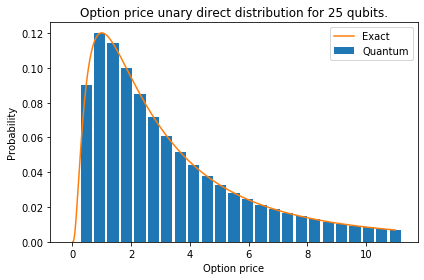

In [40]:
#Plot the probabilities of the circuit against the classical gaussian probabilities
width = (S[1]-S[0])/1.2
if lognormal==True:
    Sp = np.linspace(0.01, S0+10*sig, 10000)
    fp = log_normal(Sp, S0, sig)
else:
    Sp = np.linspace(S0-3*sig, S0+3*sig, 10000)
    fp = gauss(Sp, S0, sig)
fig, ax = plt.subplots()
#rects1 = ax.bar(S-width/2, g, width, label='Exact')
rects2 = ax.bar(S, dir_r, width, label='Quantum')
ax.plot(Sp, max(dir_r)*fp/max(fp), 'C1', label='Exact')

#ax.vlines(K, 0, max(dir_r), linestyles='dashed', label='K = {}'.format(K))
plt.ylabel('Probability')
plt.xlabel('Option price')
plt.title('Option price unary direct distribution for {} qubits.'.format(qu))
ax.legend()


fig.tight_layout()

#savefig('{}qubits_Comparision.png'.format(qu), bbox_inches='tight')

plt.show()

In [41]:
#Run the optmized circuit with the pay-off circuit
C = DirectCircuit(qu, direct_parameters)
C = PayoffCircuit(qu, C, K, S)

In [43]:
#Compute the classical precise pay-off and compare it with the one found quantically
CP, QP = Payoff(qu, K, S0, sig, C, S, lognormal=lognormal)

print('With precision {}'.format(10000))
print('Classical Pay-off: {}'.format(CP))
print('')
print('With precision {} qubits and {} samples'.format(qu, 10000))
print('Quantum Pay-off: {}'.format(QP))
print('')
print('Percentage off: {}%'.format(np.abs(100*(CP-QP)/(CP))))

With precision 10000
Classical Pay-off: 0.9585879075499748

With precision 25 qubits and 10000 samples
Quantum Pay-off: 0.9713

Percentage off: 1.326126936288576%
